In [1]:

from river.drift import ADWIN
from river import forest
from river import tree
import pandas as pd
import seaborn as sns
from river import anomaly
from river import metrics
import matplotlib.pyplot as plt
from river import stats

In [4]:
data = pd.read_csv("Heart Attack.csv")

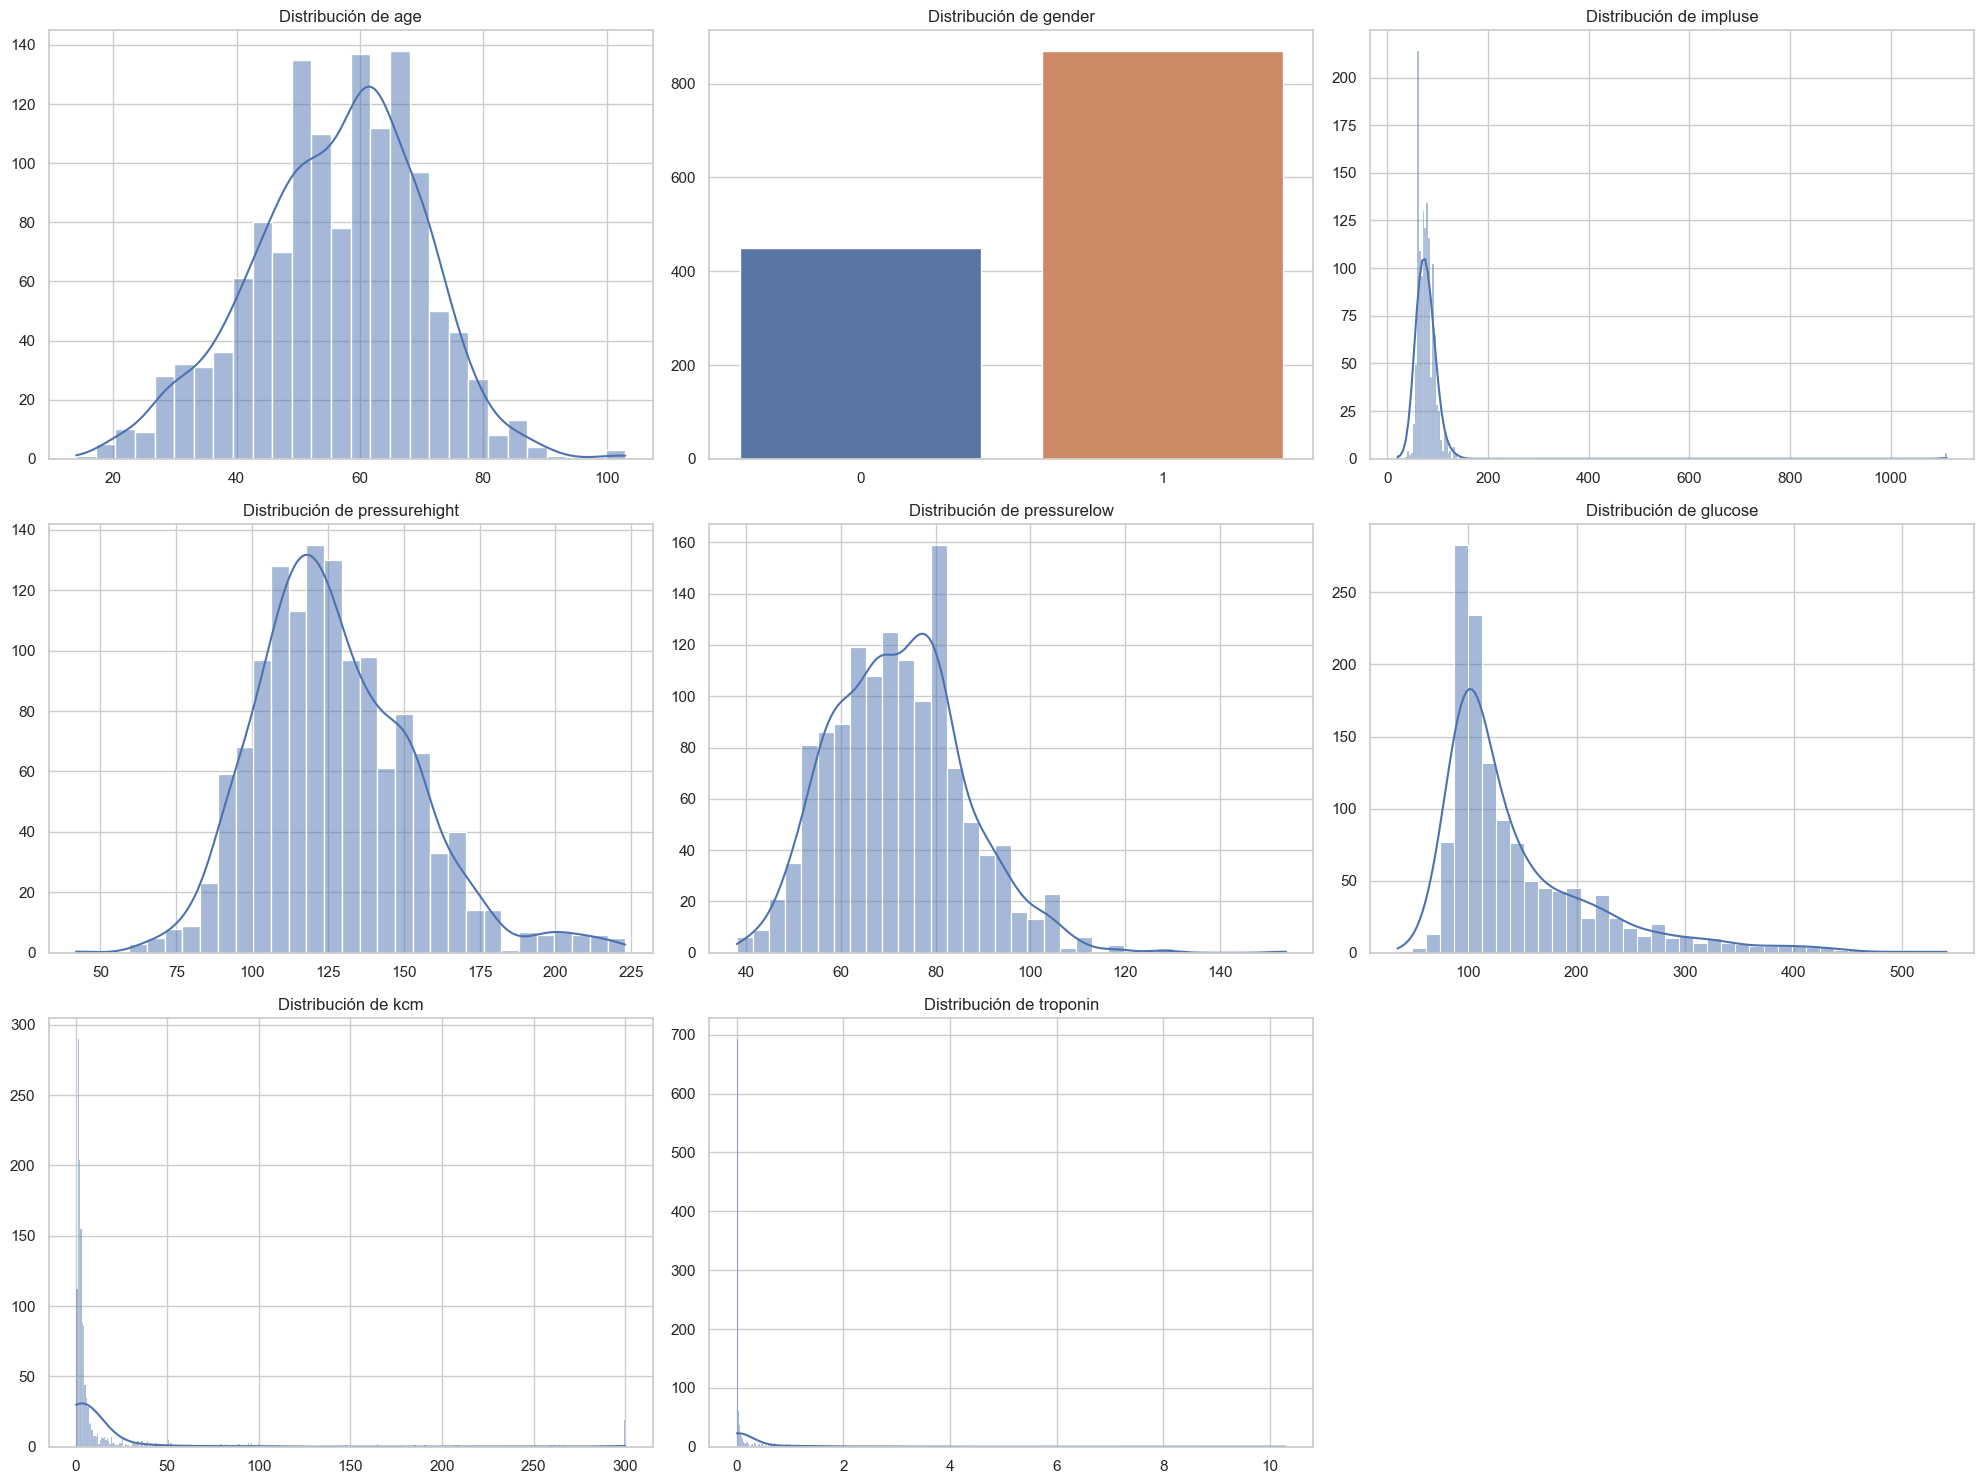

In [5]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(20, 15))
dataplot = data.copy()
# Lista de las columnas a representar
columns = dataplot.columns.drop('class')

# Creamos un subplot para cada columna
for i, column in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    if dataplot[column].dtype == 'object' or column == 'gender':
        sns.countplot(x=column, data=data)
    else:
        sns.histplot(data[column], kde=True)
    plt.title(f'Distribución de {column}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

### MODELOS SIN TRATAMIENTO DE OUTLIERS

primero vamos a ver como funcionan los modelos sin tratar los outliers

Accuracy at instance 0: 0.00
Accuracy at instance 1: 0.00
Accuracy at instance 2: 0.33
Accuracy at instance 3: 0.25
Accuracy at instance 4: 0.40
Accuracy at instance 5: 0.50
Accuracy at instance 6: 0.57
Accuracy at instance 7: 0.50
Accuracy at instance 8: 0.56
Accuracy at instance 9: 0.60
Accuracy at instance 10: 0.64
Accuracy at instance 11: 0.67
Accuracy at instance 12: 0.62
Accuracy at instance 13: 0.64
Accuracy at instance 14: 0.67
Accuracy at instance 15: 0.62
Accuracy at instance 16: 0.65
Accuracy at instance 17: 0.67
Accuracy at instance 18: 0.68
Accuracy at instance 19: 0.65
Accuracy at instance 20: 0.67
Accuracy at instance 21: 0.64
Accuracy at instance 22: 0.65
Accuracy at instance 23: 0.62
Accuracy at instance 24: 0.64
Accuracy at instance 25: 0.65
Accuracy at instance 26: 0.67
Accuracy at instance 27: 0.68
Accuracy at instance 28: 0.69
Accuracy at instance 29: 0.67
Accuracy at instance 30: 0.65
Accuracy at instance 31: 0.62
Accuracy at instance 32: 0.61
Accuracy at instance

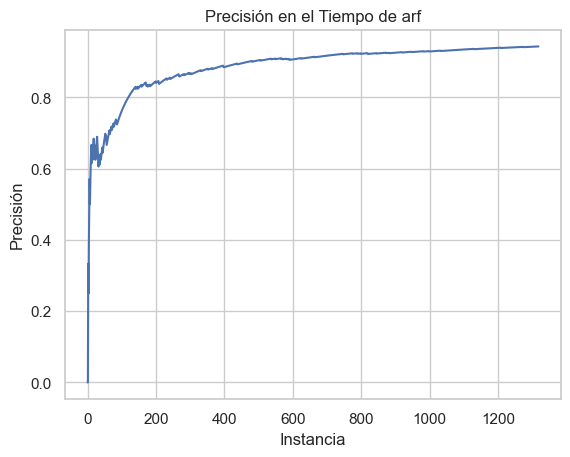

F1 Score: 0.00
MCC Score: 0.00
Accuracy at instance 0: 0.00
Accuracy at instance 1: 0.00
Accuracy at instance 2: 0.00
Accuracy at instance 3: 0.00
Accuracy at instance 4: 0.00
Accuracy at instance 5: 0.17
Accuracy at instance 6: 0.29
Accuracy at instance 7: 0.25
Accuracy at instance 8: 0.33
Accuracy at instance 9: 0.40
Accuracy at instance 10: 0.45
Accuracy at instance 11: 0.50
Accuracy at instance 12: 0.46
Accuracy at instance 13: 0.50
Accuracy at instance 14: 0.53
Accuracy at instance 15: 0.50
Accuracy at instance 16: 0.47
Accuracy at instance 17: 0.50
Accuracy at instance 18: 0.53
Accuracy at instance 19: 0.50
Accuracy at instance 20: 0.52
Accuracy at instance 21: 0.50
Accuracy at instance 22: 0.48
Accuracy at instance 23: 0.46
Accuracy at instance 24: 0.44
Accuracy at instance 25: 0.42
Accuracy at instance 26: 0.44
Accuracy at instance 27: 0.46
Accuracy at instance 28: 0.45
Accuracy at instance 29: 0.47
Accuracy at instance 30: 0.45
Accuracy at instance 31: 0.47
Accuracy at instanc

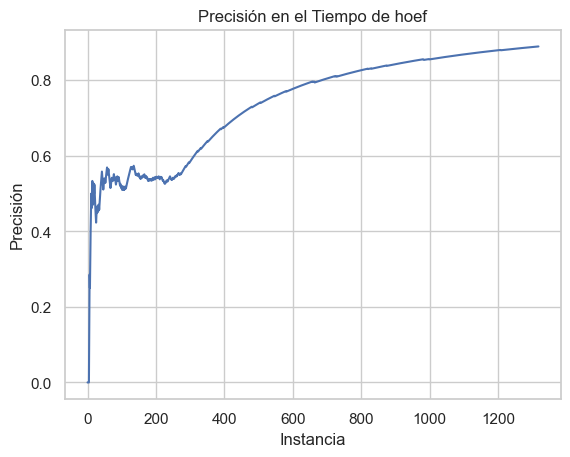

F1 Score: 0.00
MCC Score: 0.00


In [29]:
modelos = {
        "arf": forest.ARFClassifier(drift_detector=ADWIN()),       
        "hoef": tree.HoeffdingAdaptiveTreeClassifier(
    drift_detector=ADWIN(), 
    drift_window_threshold=50,
    grace_period=20
)
    }

# Inicializar métricas
f1 = metrics.F1()
mcc = metrics.MCC()


    
for nombre, modelo in modelos.items():
    accuracy = metrics.Accuracy()  
    accuracies = []
        
    for i, row in data.iterrows():
        x = row.drop(['class'])
        y = row['class']
        # Detección de outliers

        y_pred = modelo.predict_one(x)
        modelo.learn_one(x, y)
        
        # Actualizar las métricas
        f1.update(y, y_pred)
        mcc.update(y, y_pred)
        accuracy.update(y, y_pred)
        print(f"Accuracy at instance {i}: {accuracy.get():.2f}")
        modelo.drift_detector.update(accuracy.get())
        if modelo.drift_detector.drift_detected:
            print(f"*** Warning: Drift detected at instance {i}, reseteamos el modelo ***")
    


    
        accuracies.append(accuracy.get())

 # Crear un gráfico de precisión en el tiempo
    plt.plot(range(len(accuracies)), accuracies)
    plt.xlabel("Instancia")
    plt.ylabel("Precisión")
    plt.title(f'Precisión en el Tiempo de {nombre}')
    plt.show()

    # Calcular métricas finales
    print(f"F1 Score: {f1.get():.2f}")
    print(f"MCC Score: {mcc.get():.2f}")
    
   


### MODELOS CON TRATAMIENTO DE OUTLIERS

Accuracy at instance 0: 0.00
Accuracy at instance 1: 0.00
Accuracy at instance 2: 0.00
Accuracy at instance 3: 0.00
Accuracy at instance 4: 0.20
Accuracy at instance 5: 0.33
Outlier detected at instance 6
valor de impulse: 40 is an outlier!
Accuracy at instance 7: 0.29
Accuracy at instance 8: 0.38
Accuracy at instance 9: 0.44
Accuracy at instance 10: 0.50
Accuracy at instance 11: 0.55
Outlier detected at instance 12
valor de impulse: 60 is an outlier!
Outlier detected at instance 13
valor de impulse: 94 is an outlier!
Outlier detected at instance 14
valor de impulse: 76 is an outlier!
Accuracy at instance 15: 0.50
Accuracy at instance 16: 0.54
Accuracy at instance 17: 0.50
Accuracy at instance 18: 0.53
Accuracy at instance 19: 0.50
Outlier detected at instance 20
valor de impulse: 92 is an outlier!
Outlier detected at instance 21
valor de impulse: 135 is an outlier!
Accuracy at instance 22: 0.53
Accuracy at instance 23: 0.50
Accuracy at instance 24: 0.53
Accuracy at instance 25: 0.55
A

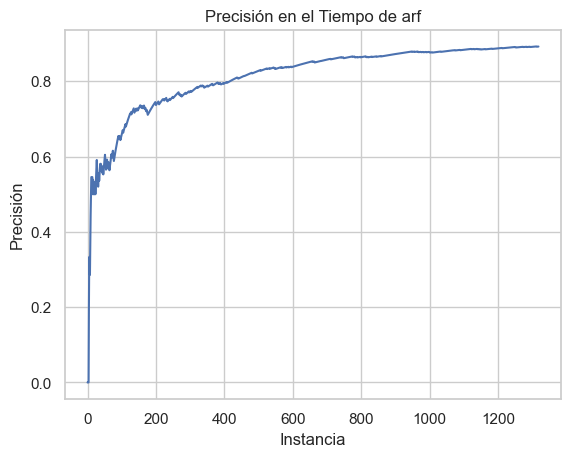

F1 Score: 0.00
MCC Score: 0.00
Accuracy at instance 0: 0.00
Accuracy at instance 1: 0.00
Accuracy at instance 2: 0.00
Accuracy at instance 3: 0.00
Accuracy at instance 4: 0.00
Accuracy at instance 5: 0.17
Outlier detected at instance 6
valor de impulse: 40 is an outlier!
Accuracy at instance 7: 0.14
Accuracy at instance 8: 0.25
Accuracy at instance 9: 0.33
Accuracy at instance 10: 0.40
Accuracy at instance 11: 0.45
Outlier detected at instance 12
valor de impulse: 60 is an outlier!
Outlier detected at instance 13
valor de impulse: 94 is an outlier!
Outlier detected at instance 14
valor de impulse: 76 is an outlier!
Accuracy at instance 15: 0.50
Accuracy at instance 16: 0.54
Accuracy at instance 17: 0.57
Accuracy at instance 18: 0.60
Accuracy at instance 19: 0.56
Outlier detected at instance 20
valor de impulse: 92 is an outlier!
Outlier detected at instance 21
valor de impulse: 135 is an outlier!
Accuracy at instance 22: 0.53
Accuracy at instance 23: 0.50
Accuracy at instance 24: 0.47


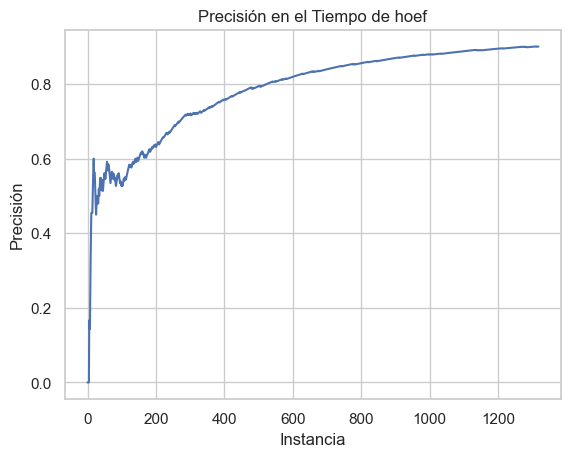

F1 Score: 0.00
MCC Score: 0.00


In [33]:
modelos = {
        "arf": forest.ARFClassifier(drift_detector=ADWIN()),       
        "hoef": tree.HoeffdingAdaptiveTreeClassifier(
    drift_detector=ADWIN(), 
    drift_window_threshold=50,
    grace_period=20
)
    }

# Inicializar métricas
f1 = metrics.F1()
mcc = metrics.MCC()

class IQR_Outlier_Detector:
    def __init__(self, factor=1.5):
        self.q1 = stats.Quantile(0.25)  # Primer cuartil
        self.q3 = stats.Quantile(0.75)  # Tercer cuartil
        self.factor = factor

    def update(self, value):
        self.q1.update(value)
        self.q3.update(value)

    def is_outlier(self, value):
        iqr = self.q3.get() - self.q1.get()
        lower_bound = self.q1.get() - self.factor * iqr
        upper_bound = self.q3.get() + self.factor * iqr

        return value < lower_bound or value > upper_bound

# Ejemplo de uso

    
for nombre, modelo in modelos.items():
    accuracy = metrics.Accuracy()  
    accuracies = []
    detector = IQR_Outlier_Detector()
      
    for i, row in data.iterrows():
        x = row.drop(['class'])
        y = row['class']
        detector.update(x[2])
        # Detección de outliers
        is_outlier = detector.is_outlier(x[2])
        
        if is_outlier == 0:
            y_pred = modelo.predict_one(x)
            modelo.learn_one(x, y)
            
            # Actualizar las métricas
            f1.update(y, y_pred)
            mcc.update(y, y_pred)
            accuracy.update(y, y_pred)
            print(f"Accuracy at instance {i}: {accuracy.get():.2f}")
            modelo.drift_detector.update(accuracy.get())
            if modelo.drift_detector.drift_detected:
                print(f"*** Warning: Drift detected at instance {i}, reseteamos el modelo ***")
        
        if is_outlier == 1:
            print(f"Outlier detected at instance {i}")
            print(f"valor de impulse: {x[2]} is an outlier!")

    
        accuracies.append(accuracy.get())

 # Crear un gráfico de precisión en el tiempo
    plt.plot(range(len(accuracies)), accuracies)
    plt.xlabel("Instancia")
    plt.ylabel("Precisión")
    plt.title(f'Precisión en el Tiempo de {nombre}')
    plt.show()

    # Calcular métricas finales
    print(f"F1 Score: {f1.get():.2f}")
    print(f"MCC Score: {mcc.get():.2f}")
    
   


VEMOS QUE EL ARF EMPEORA Y EL HOEFFDING MEJORA